# Making a complete dataset for the MVP

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

data_path = os. getcwd()[:-9] +'Data/'

In [2]:
df =  pd.read_csv(data_path+'df_imputed_fulldf.csv')
df.time_bin = pd.to_datetime(df.time_bin)

In [3]:
print('Number of duplicated timebin:', len(df)-len(df.groupby('time_bin').count()))

Number of duplicated timebin: 541


In [4]:
# check the nona data
df_nona = pd.read_csv(data_path+'df_full_nona.csv')
df_nona.time_bin = pd.to_datetime(df_nona.time_bin)

In [5]:
print('Number of duplicated timebin:', len(df_nona)-len(df_nona.groupby('time_bin').count()))

Number of duplicated timebin: 379


In [6]:
# check the df_imputed data
df_imp = pd.read_csv(data_path+'df_imputed.csv')
df_imp.time_bin = pd.to_datetime(df_imp.time_bin)
print('Number of duplicated timebin:', len(df_imp)-len(df_imp.groupby('time_bin').count()))

Number of duplicated timebin: 0


**Observations:**
- Looks like the duplicated timebins are created when adding weather and populartimes data
- Redo adding weather and populartimes data

**But first, make all labels to 0 and 1**

In [7]:
# check the labels
df_imp.label.value_counts()

1.000000    235
0.000000    233
0.500000     26
0.666667      9
0.333333      7
0.750000      2
0.200000      1
0.777778      1
0.800000      1
Name: label, dtype: int64

In [8]:
# set labels more than o.5 to 1, less than or equal to 0.5 to 0.
df_imp.loc[df_imp.label>0.5,'label']= 1
df_imp.loc[df_imp.label<= 0.5,'label'] = 0

In [9]:
df_imp.label.value_counts()

0.0    267
1.0    248
Name: label, dtype: int64

In [10]:
df_imp.dropna(inplace=True)
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 30 to 2047
Data columns (total 3 columns):
time_bin    515 non-null datetime64[ns]
label       515 non-null float64
source      515 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 16.1+ KB


In [11]:
df_imp.sort_values(by='time_bin',inplace=True)

In [12]:
df_imp.reset_index(drop=True,inplace=True)

## Add populartimes data

In [13]:
curpop_df =  pd.read_csv(data_path+'curpop_df.csv')
curpop_df['time_bin'] = pd.to_datetime(curpop_df.time_bin)

In [14]:
curpop_df.head(3)

,current_popularity,datetime,time_bin
0,38,4/2/2020 15:17,2020-04-02 15:05:00
1,39,4/2/2020 15:27,2020-04-02 15:20:00
2,38,4/2/2020 15:37,2020-04-02 15:35:00


In [15]:
df_imp_full = df_imp.join(curpop_df[['current_popularity','time_bin']].set_index('time_bin'), on='time_bin')

In [16]:
df_imp_full.head(3)

,time_bin,label,source,current_popularity
0,2020-03-23 14:35:00,0.0,mis/imp,NaN
1,2020-03-23 14:50:00,0.0,obs,NaN
2,2020-03-23 15:05:00,0.0,mis/imp,NaN


In [17]:
# look into where current_popularity data is missing
missing_pop = df_imp_full[df_imp_full.current_popularity.isna()]
print(f'{len(missing_pop)} data points is missing for current_popularity')
df_imp_full[df_imp_full.current_popularity.isna()].tail(3)

50 data points is missing for current_popularity


,time_bin,label,source,current_popularity
47,2020-04-01 15:20:00,0.0,obs,NaN
48,2020-04-01 15:35:00,0.0,mis/imp,NaN
49,2020-04-01 15:50:00,0.0,mis/imp,NaN


This makes sense as current popularity data is only collected starting April 2nd. However, the 50 data points missing are likely to be valualbe. Fill them in with the histroical average. 

In [18]:
# loading histroical average. 
weekpop_df =  pd.read_csv(data_path+'weekpop_df.csv', index_col=[0])

In [19]:
byhr_df= weekpop_df.data.apply(lambda x: x[1:-1].split(',')).apply(pd.Series)

In [20]:
# only 6 to 9pm are relevant. Transpose the data frame such that columns are dat of the week, rows are populartime for the hour
byhr_df = byhr_df.loc[:,5:20].transpose()
byhr_df.head(3)

,0,1,2,3,4,5,6
5,0,2,1,1,1,1,2
6,4,7,5,6,6,5,4
7,10,12,11,13,14,14,8


In [21]:
for i in missing_pop.index:
    tbin = missing_pop.time_bin.loc[i]
    missing_pop.loc[i,'current_popularity'] =byhr_df.loc[tbin.hour,tbin.dayofweek]

C:\Users\Huayi\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
df_imp_full.loc[:missing_pop.index[-1]+1,:] = missing_pop

In [23]:
df_imp_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 4 columns):
time_bin              514 non-null datetime64[ns]
label                 514 non-null float64
source                514 non-null object
current_popularity    514 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 16.2+ KB


## Add current weather data

In [24]:
current_weather = pd.read_csv(data_path+'binned_current_log.csv')
weather_hist= pd.read_csv(data_path + 'binned_weather_history.csv')
current_weather['time_bin'] = pd.to_datetime(current_weather.time_bin)
weather_hist['time_bin'] = pd.to_datetime(weather_hist.time_bin)

In [25]:
print('Number of observations per group')
current_weather.groupby(['status','detailed_status']).clouds.agg(['count','mean','std','max','min'])

Number of observations per group


count       mean        std  \
status       detailed_status                                             
Clear        clear sky                       619   1.000000   0.000000   
Clouds       broken clouds                   144  75.000000   0.000000   
             clear sky                        15  38.000000  10.423569   
             few clouds                      118  21.165254  10.276114   
             overcast clouds                 349  88.782235   6.754369   
             scattered clouds                152  40.009868   9.722686   
Mist         mist                              3  90.000000   0.000000   
             overcast clouds                   3  90.000000   0.000000   
Rain         heavy intensity rain              6  90.000000   0.000000   
             light rain                      229  86.590975  15.344004   
             mist                              6  90.000000   0.000000   
             moderate rain                   112  88.288690   5.860447   
             overcast clouds                  14  90.000000   0.000000   
Thunderstorm thunderstorm with light rain      2  90.000000   0.000000   
             thunderstorm with rain            3  90.000000   0.000000   

                                                 max        min  
status       detailed_status                                     
Clear        clear sky                      1.000000   1.000000  
Clouds       broken clouds                 75.000000  75.000000  
             clear sky                     50.333333  25.666667  
             few clouds                    56.666667   7.333333  
             overcast clouds               90.000000  30.666667  
             scattered clouds              73.333333  14.000000  
Mist         mist                          90.000000  90.000000  
             overcast clouds               90.000000  90.000000  
Rain         heavy intensity rain          90.000000  90.000000  
             light rain                    90.000000   1.000000  
             mist                          90.000000  90.000000  
             moderate rain                 90.000000  43.333333  
             overcast clouds               90.000000  90.000000  
Thunderstorm thunderstorm with light rain  90.000000  90.000000  
             thunderstorm with rain        90.000000  90.000000

In [26]:
## good, maybe, bad

good = ['clear sky','few clouds']
maybe = ['scattered clouds','mist','light rain','broken clouds']
bad = ['heavy intensity rain','moderate rain','overcast clouds','thunderstorm with rain','thunderstorm with light rain']

In [27]:
import numpy as np
current_weather['status_good'] = np.zeros(len(current_weather))
current_weather['status_maybe'] = np.zeros(len(current_weather))
current_weather['status_bad'] = np.zeros(len(current_weather))

In [28]:
current_weather.loc[current_weather.detailed_status.isin(good),'status_good'] =1
current_weather.loc[current_weather.detailed_status.isin(maybe),'status_maybe'] =1
current_weather.loc[current_weather.detailed_status.isin(bad),'status_bad'] =1

In [29]:
current_weather.head(3)

,time_bin,clouds,rain_1h,snow_1h,wind_speed,wind_deg,humidity,press,temp,temp_feels,temp_max,temp_min,park_name,sunrise_time,sunset_time,status,detailed_status,status_good,status_maybe,status_bad
0,2020-04-04 08:35:00,90.0,0.25,0.0,5.1,40.0,93.0,1016.0,46.40,38.70,48.2,44.6,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain,0.0,1.0,0.0
1,2020-04-04 08:50:00,90.0,0.25,0.0,4.6,40.0,93.0,1016.0,46.60,39.56,48.2,44.6,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain,0.0,1.0,0.0
2,2020-04-04 09:05:00,90.0,0.00,0.0,4.6,40.0,93.0,1016.0,46.69,39.67,48.2,44.6,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain,0.0,1.0,0.0


In [30]:
# get a subset of critical columns
current_weather_sub = current_weather[['time_bin','wind_speed','temp','status_good','status_maybe','status_bad']]

In [32]:
current_weather_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 6 columns):
time_bin        1775 non-null datetime64[ns]
wind_speed      1775 non-null float64
temp            1775 non-null float64
status_good     1775 non-null float64
status_maybe    1775 non-null float64
status_bad      1775 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 83.3 KB


In [36]:
df_imp_full = df_imp_full.join(current_weather_sub.set_index('time_bin'), on='time_bin')

In [37]:
# weather before 2020-04-04 8:35 are missing. 
df_imp_full.head(3)

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad
0,2020-03-23 14:35:00,0.0,mis/imp,42,NaN,NaN,NaN,NaN,NaN
1,2020-03-23 14:50:00,0.0,obs,42,NaN,NaN,NaN,NaN,NaN
2,2020-03-23 15:05:00,0.0,mis/imp,43,NaN,NaN,NaN,NaN,NaN


In [38]:
df_imp_full.tail(3)

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad
512,2020-04-26 14:50:00,0.0,obs,19,9.8,47.466667,0.0,1.0,0.0
513,2020-04-26 15:05:00,0.0,mis/imp,14,9.8,47.433333,0.0,1.0,0.0
514,2020-04-26 15:20:00,0.0,mis/imp,13,9.8,47.446667,0.0,1.0,0.0


In [39]:
df_imp_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 9 columns):
time_bin              514 non-null datetime64[ns]
label                 514 non-null float64
source                514 non-null object
current_popularity    514 non-null object
wind_speed            360 non-null float64
temp                  360 non-null float64
status_good           360 non-null float64
status_maybe          360 non-null float64
status_bad            360 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 36.3+ KB


In [74]:
missing_weather = df_imp_full[df_imp_full.isna().temp]

In [75]:
len(missing_weather)

155

In [83]:
# temp and wind_speed can be filled with historical data
len(weather_hist[weather_hist.time_bin.isin(missing_weather.time_bin)].temp)

154

In [87]:
weather_fill = weather_hist[weather_hist.time_bin.isin(missing_weather.time_bin)]

In [92]:
missing_weather.loc[missing_weather.time_bin.isin(weather_fill.time_bin.values),'temp'] = weather_fill.temp.values
missing_weather.loc[missing_weather.time_bin.isin(weather_fill.time_bin.values),'wind_speed'] = weather_fill.wind_speed.values

In [93]:
missing_weather[missing_weather.temp.isna()] # get rid of this line later

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad
50,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# next, look into filling the status. 
# missing values on and after 2020,4,4 can have their status filled by the value of ajacent time
# but for dates before that, I looked up historical weather online and gave a rough estimation 
missing_weather.time_bin.dt.date.unique()

array([datetime.date(2020, 3, 23), datetime.date(2020, 3, 25),
       datetime.date(2020, 3, 26), datetime.date(2020, 3, 28),
       datetime.date(2020, 3, 29), datetime.date(2020, 3, 31),
       datetime.date(2020, 4, 1), NaT, datetime.date(2020, 4, 2),
       datetime.date(2020, 4, 3), datetime.date(2020, 4, 4),
       datetime.date(2020, 4, 5), datetime.date(2020, 4, 6),
       datetime.date(2020, 4, 8), datetime.date(2020, 4, 9),
       datetime.date(2020, 4, 13), datetime.date(2020, 4, 14),
       datetime.date(2020, 4, 15), datetime.date(2020, 4, 16),
       datetime.date(2020, 4, 17), datetime.date(2020, 4, 18),
       datetime.date(2020, 4, 20), datetime.date(2020, 4, 21),
       datetime.date(2020, 4, 22)], dtype=object)

#### Filling the status
I used historical record from weather.com, taken into consideration the amount of rain (below)
- 03/23. Mostly Cloudy. But also rained. status_bad
- 03/25. Fair (Not Clear bu close). status_good
- 03/26. Clear. status_good
- 03/28. Partly Cloudy. status_maybe
- 03/29. Cloudy. status_maybe
- 03/31. light Rain. status_maybe
- 04/01. Cloudy. status_maybe
- 04/02. Clear. status_good
- 04/03. Cloudy. status_maybe

<IPython.core.display.Javascript object>


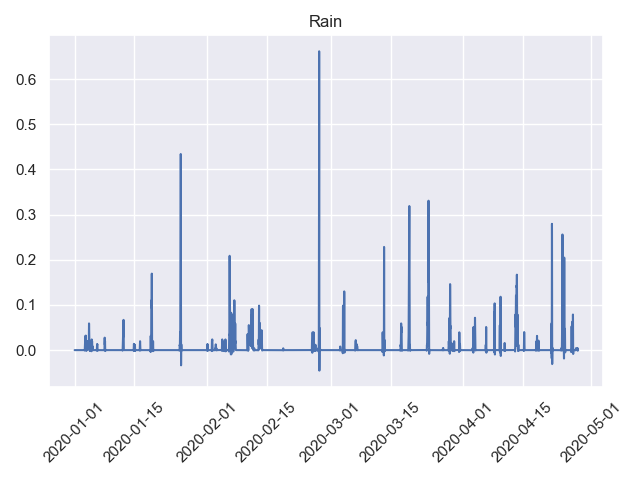

In [114]:
plt.figure()
plt.plot(weather_hist.time_bin,weather_hist.rain_1h)
plt.xticks(rotation=45)
plt.title('Rain')
plt.tight_layout()
plt.show()

In [123]:
fill_dates = missing_weather.time_bin.dt.date.unique()[missing_weather.time_bin.dt.date.unique() < current_weather.time_bin.dt.date[0]]

In [128]:
imputed_status= ['status_bad','status_good','status_good','status_maybe','status_maybe','status_maybe','status_maybe','status_good','status_maybe']


In [132]:
# fill all three status columns within those dates with zeros first
missing_weather.loc[missing_weather.time_bin.dt.date.isin(fill_dates),['status_good','status_maybe','status_bad']] = 0

In [135]:
for n,i in enumerate(fill_dates):
    missing_weather.loc[missing_weather.time_bin.dt.date == i,imputed_status[n]] =1

In [143]:
# now, fill missing value on 2020/4/4 and beyond

# first join back
df_imp_full.loc[df_imp_full.time_bin.isin(missing_weather.time_bin)] = missing_weather

In [144]:
# then drop line 50 which contains invalid time
df_imp_full.drop(index=50, inplace=True)

In [151]:
# fill value based on previous value
df_imp_full.fillna(method='ffill', inplace=True)

In [152]:
df_imp_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 514
Data columns (total 9 columns):
time_bin              514 non-null datetime64[ns]
label                 514 non-null float64
source                514 non-null object
current_popularity    514 non-null object
wind_speed            514 non-null float64
temp                  514 non-null float64
status_good           514 non-null float64
status_maybe          514 non-null float64
status_bad            514 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 40.2+ KB


In [153]:
df_imp_full.label.value_counts()

0.0    266
1.0    248
Name: label, dtype: int64

In [162]:
df_imp_full.groupby('label').sum()[['status_good','status_maybe','status_bad']]

,status_good,status_maybe,status_bad
label,,,
0.0,100.0,114.0,52.0
1.0,136.0,71.0,41.0


In [182]:
df_imp_full.reset_index(inplace=True, drop=True)

In [183]:
df_imp_full['dayofweek'] = df_imp_full.time_bin.dt.dayofweek
df_imp_full['hour'] = df_imp_full.time_bin.dt.hour

In [190]:
df_imp_full.to_csv(data_path+'df_mvp.csv',index=False)

In [188]:
df_imp_full.describe()

,label,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour
count,514.00000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.48249,10.260956,52.269325,0.459144,0.359922,0.180934,2.992218,13.731518
std,0.50018,11.003264,6.493995,0.498813,0.480445,0.385338,2.132076,3.745029
min,0.00000,1.200000,36.653233,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.00000,3.100000,47.072500,0.000000,0.000000,0.000000,1.000000,11.000000
50%,0.00000,5.100000,51.670000,0.000000,0.000000,0.000000,3.000000,14.000000
75%,1.00000,16.083539,57.455731,1.000000,1.000000,0.000000,5.000000,17.000000
max,1.00000,47.410617,65.070000,1.000000,1.000000,1.000000,6.000000,20.000000


In [189]:
df_imp_full.head()

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour
0,2020-03-23 14:35:00,0.0,mis/imp,42,26.598094,37.846753,0.0,0.0,1.0,0,14
1,2020-03-23 14:50:00,0.0,obs,42,25.900000,37.940000,0.0,0.0,1.0,0,14
2,2020-03-23 15:05:00,0.0,mis/imp,43,26.427817,38.125302,0.0,0.0,1.0,0,15
3,2020-03-23 15:20:00,0.0,mis/imp,43,28.181545,38.402658,0.0,0.0,1.0,0,15
4,2020-03-25 12:50:00,0.0,mis/imp,31,18.400000,42.080000,1.0,0.0,0.0,2,12
